In [279]:
import pandas as pd
import numpy as np
import json
import autogluon
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import shap
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.cluster import HDBSCAN


## 1. Create different datasets based on the store. (Different in sizes and distributions)

In [280]:
main_train_df = pd.read_csv("main_train_df.csv")

In [281]:
# A dict of all the store branches
stores = {}
for store_id in main_train_df["Store"].unique():
    df_store = main_train_df[main_train_df["Store"] == store_id]
    stores[f"store_{store_id}"] = df_store

In [282]:
stores["store_2"].columns

Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'Sales'],
      dtype='object')

In [283]:
len(stores)

1115

## 2. Compute metadata info

In [284]:
# The system learns to choose the best model based on dataset characteristics.

In [285]:
global_predictor = TabularPredictor.load("AutogluonModels_5min/")

In [286]:
for name, df in stores.items():
    # Get predictions for this store
    preds = global_predictor.predict(df)
    
    # Ensure preds is a Series aligned with the DataFrame's index
    if not isinstance(preds, pd.Series):
        preds = pd.Series(preds, index=df.index)
    
    # Assign to a new column in the DataFrame
    df["PredictedSales"] = preds

/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_4913/76635908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PredictedSales"] = preds
/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_4913/76635908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PredictedSales"] = preds
/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_4913/76635908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [423]:
for name, df in stores.items():
    df = df.copy()  # ensure we are working on a fresh copy
    for col in ["Promo2SinceWeek", "Promo2SinceYear"]:
        if col in df:
            df.loc[:, col] = df[col].fillna(0)  # use .loc to avoid the warning
    stores[name] = df  # update the dict


In [424]:
stores["store_44"]

,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,Sales,PredictedSales
0,44,2,763,1,1,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2014,5,6,19,7076,6852.701172
70,44,6,444,1,0,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2013,11,2,44,3475,3793.796875
1868,44,4,803,1,1,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2014,10,2,40,6765,7033.255371
1943,44,1,893,1,1,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2014,5,5,19,8705,8431.151367
3935,44,7,0,0,0,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2015,4,26,17,0,-1.000799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809638,44,3,566,1,0,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2013,11,13,46,4404,4361.350586
811200,44,2,757,1,1,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2015,4,14,16,6804,6975.656250
811922,44,2,740,1,1,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2013,9,10,37,7104,6776.454102
812647,44,6,424,1,0,0,0,a,a,540.0,...,2011.0,0,0.0,0.0,2013,1,26,4,3324,3444.233398


In [183]:
'''
# Prevoius simple meta data calculation which did not capture everything fully 
def compute_metadata(df):
    return {
        "num_rows": len(df),
        "promo_fraction": df["Promo"].mean(),
        "promo2_fraction": df["Promo2"].mean(),
        "schoolholiday_fraction": df["SchoolHoliday"].mean(),
        "mean_sales": df["Sales"].mean(),
        "std_sales": df["Sales"].std()
    }
'''

'\n# Prevoius simple meta data calculation which did not capture everything fully \ndef compute_metadata(df):\n    return {\n        "num_rows": len(df),\n        "promo_fraction": df["Promo"].mean(),\n        "promo2_fraction": df["Promo2"].mean(),\n        "schoolholiday_fraction": df["SchoolHoliday"].mean(),\n        "mean_sales": df["Sales"].mean(),\n        "std_sales": df["Sales"].std()\n    }\n'

In [ ]:
'''
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def compute_metadata(df):
    meta = {}

    # ---------------------------------------------------
    # 1. Dataset size
    # ---------------------------------------------------
    meta["num_rows"] = len(df)

    # ---------------------------------------------------
    # 2. Temporal distribution entropy
    # ---------------------------------------------------
    for col in ["DayOfWeek", "Month", "WeekOfYear"]:
        if col in df:
            p = df[col].value_counts(normalize=True)
            meta[f"{col.lower()}_entropy"] = -(p * np.log2(p + 1e-12)).sum()
        else:
            meta[f"{col.lower()}_entropy"] = 0.0

    # ---------------------------------------------------
    # 3. Binary feature fractions
    # ---------------------------------------------------
    for col in ["Promo", "Promo2", "SchoolHoliday", "Open"]:
        if col in df:
            meta[f"{col.lower()}_fraction"] = df[col].mean()
        else:
            meta[f"{col.lower()}_fraction"] = 0.0

    # ---------------------------------------------------
    # 4. Competition distance statistics
    # ---------------------------------------------------
    if "CompetitionDistance" in df:
        values = df["CompetitionDistance"].fillna(df["CompetitionDistance"].median())
        meta["competition_distance_mean"] = values.mean()
        meta["competition_distance_std"] = values.std()
    else:
        meta["competition_distance_mean"] = 0.0
        meta["competition_distance_std"] = 0.0

    # ---------------------------------------------------
    # 5. Feature distribution shape (skew, kurtosis, CV)
    # ---------------------------------------------------
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    per_feature_skew = []
    per_feature_kurt = []
    per_feature_cv   = []

    for col in numeric_cols:
        col_values = df[col].dropna().values

        if len(col_values) > 1:
            series = pd.Series(col_values)
            per_feature_skew.append(series.skew())
            per_feature_kurt.append(series.kurtosis())
            per_feature_cv.append(np.std(col_values) / (np.mean(col_values) + 1e-9))
        else:
            per_feature_skew.append(0)
            per_feature_kurt.append(0)
            per_feature_cv.append(0)

    meta["avg_skewness"] = np.mean(per_feature_skew)
    meta["avg_kurtosis"] = np.mean(per_feature_kurt)
    meta["avg_coef_variation"] = np.mean(per_feature_cv)
    meta["std_coef_variation"] = np.std(per_feature_cv)

    # ---------------------------------------------------
    # 6. PCA: intrinsic dimensionality
    # ---------------------------------------------------
    try:
        scaled = df[numeric_cols].fillna(df[numeric_cols].median())
        pca = PCA()
        pca.fit(scaled)

        meta["pca_var_first"] = pca.explained_variance_ratio_[0]
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        meta["pca_components_90"] = int(np.searchsorted(cumvar, 0.90) + 1)

    except Exception:
        meta["pca_var_first"] = 0.0
        meta["pca_components_90"] = len(numeric_cols)

    # ---------------------------------------------------
    # 7. Prediction-based difficulty metrics
    # ---------------------------------------------------
    # Only possible if we have PredictedSales
    if "PredictedSales" in df:
        meta["predsales_mean"] = df["PredictedSales"].mean()
        meta["predsales_std"] = df["PredictedSales"].std()
        meta["predsales_cv"]  = df["PredictedSales"].std() / (df["PredictedSales"].mean() + 1e-9)

    else:
        # inference data before prediction
        meta["predsales_mean"] = None
        meta["predsales_std"] = None
        meta["predsales_cv"] = None
        meta["rmse"] = None

    return meta

'''


In [485]:
def compute_metadata(df):
    meta = {}

    # 1. Dataset size
  
    meta["num_rows"] = len(df)


    # 2. Predicted Sales statistics

    if "PredictedSales" in df:
        sales = df["PredictedSales"].replace(0, np.nan).dropna()

        meta["sales_mean"] = sales.mean()
        meta["sales_std"] = sales.std()
        meta["sales_cv"] = sales.std() / (sales.mean() + 1e-9)

        # Skew and kurtosis tell you whether the store has spikes
        meta["sales_skew"] = sales.skew()
        meta["sales_kurtosis"] = sales.kurtosis()

        # How often the store is closed
        meta["closed_fraction"] = (df["Open"] == 0).mean() if "Open" in df else 0.0
    else:
        meta["sales_mean"] = None
        meta["sales_std"] = None
        meta["sales_cv"] = None
        meta["sales_skew"] = None
        meta["sales_kurtosis"] = None
        meta["closed_fraction"] = None


    # 3. Weekend vs weekday pattern

    if "Sales" in df and "DayOfWeek" in df:
        weekday_sales = df.groupby("DayOfWeek")["Sales"].mean()
        meta["weekend_ratio"] = weekday_sales.get(6, 0) / (weekday_sales.mean() + 1e-9)
    else:
        meta["weekend_ratio"] = None



    #5. Customers Mean and std
    meta["customers_mean"] = df["Customers"].mean()
    meta["customers_std"] = df["Customers"].std()



    # 6. Intrinsic dimensionality (PCA)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    try:
        scaled = df[numeric_cols].fillna(df[numeric_cols].median())
        pca = PCA()
        pca.fit(scaled)
        meta["pca_var_first"] = pca.explained_variance_ratio_[0]
        meta["pca_components_90"] = int(np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.90) + 1)
    except Exception:
        meta["pca_var_first"] = 0.0
        meta["pca_components_90"] = len(numeric_cols)

    
    # 7. Categorical store features (ordinal encoding)
   
    store_type_map = {"a": 0, "b": 1, "c": 2, "d": 3}
    assortment_map = {"a": 0, "b": 1, "c": 2}

    if "StoreType" in df:
        meta["store_type"] = store_type_map.get(df["StoreType"].iloc[0], -1)
    else:
        meta["store_type"] = -1

    if "Assortment" in df:
        meta["assortment"] = assortment_map.get(df["Assortment"].iloc[0], -1)
    else:
        meta["assortment"] = -1



    # 8. Competition distance stats
    
    if "CompetitionDistance" in df:
        comp = df["CompetitionDistance"].fillna(df["CompetitionDistance"].median())
        meta["competition_mean"] = comp.mean()
        meta["competition_std"] = comp.std()
    else:
        meta["competition_mean"] = None
        meta["competition_std"] = None

    return meta


## 3. Build a dataset of datasets

In [486]:
meta_rows = []
for name, df in stores.items():
    m = compute_metadata(df)
    m["label"] = name      # group name
    meta_rows.append(m)

meta_df = pd.DataFrame(meta_rows)

/opt/anaconda3/envs/ag/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/ag/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/ag/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [487]:
meta_df["competition_mean"].fillna(meta_df["competition_mean"].mean() , inplace=True)
meta_df["competition_std"].fillna(meta_df["competition_std"].mean() , inplace=True)

/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_4913/3071465652.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_df["competition_mean"].fillna(meta_df["competition_mean"].mean() , inplace=True)
/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_4913/3071465652.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object 

In [488]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_rows           1115 non-null   int64  
 1   sales_mean         1115 non-null   float32
 2   sales_std          1115 non-null   float32
 3   sales_cv           1115 non-null   float32
 4   sales_skew         1115 non-null   float32
 5   sales_kurtosis     1115 non-null   float32
 6   closed_fraction    1115 non-null   float64
 7   weekend_ratio      1115 non-null   float64
 8   customers_mean     1115 non-null   float64
 9   customers_std      1115 non-null   float64
 10  pca_var_first      1115 non-null   float64
 11  pca_components_90  1115 non-null   int64  
 12  store_type         1115 non-null   int64  
 13  assortment         1115 non-null   int64  
 14  competition_mean   1115 non-null   float64
 15  competition_std    1115 non-null   float64
 16  label              1115 

In [489]:
meta_df.to_csv("meta_df.csv", index = False)

In [490]:
meta_df = pd.read_csv("meta_df.csv")
meta_df

,num_rows,sales_mean,sales_std,sales_cv,sales_skew,sales_kurtosis,closed_fraction,weekend_ratio,customers_mean,customers_std,pca_var_first,pca_components_90,store_type,assortment,competition_mean,competition_std,label
0,743,4593.7140,2435.7651,0.530239,-0.506928,-0.041492,0.160162,0.829754,537.504711,265.109817,0.997754,1,0,0,540.0,0.0,store_44
1,741,5661.2210,2928.6194,0.517312,-0.786354,0.092722,0.172740,0.939018,514.367072,258.919846,0.000000,18,0,2,8090.0,0.0,store_346
2,754,5204.5977,2756.3560,0.529600,-0.568414,-0.033909,0.157825,0.800631,691.066313,344.848645,0.000000,18,0,2,670.0,0.0,store_331
3,761,5704.5786,2961.0244,0.519061,-0.701369,0.099789,0.168200,1.059587,474.249671,231.376864,0.997550,1,3,2,9230.0,0.0,store_572
4,760,10132.8430,6128.6270,0.604828,-0.221403,-0.675996,0.171053,0.553850,1120.869565,638.839728,0.996584,1,0,2,210.0,0.0,store_1014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,5103.3135,2652.5212,0.519764,-0.792899,0.236228,0.170929,0.962292,546.318977,267.520106,0.996651,1,3,2,15720.0,0.0,store_588
1111,739,3603.9182,2032.6263,0.564005,-0.292446,0.045020,0.162382,0.755790,437.604871,222.133675,0.000000,18,0,0,2320.0,0.0,store_486
1112,770,5511.5947,3165.9922,0.574424,-0.402313,-0.381137,0.181818,0.772786,607.420779,327.400547,0.998231,1,0,0,7240.0,0.0,store_917
1113,751,7614.8384,3988.4440,0.523773,-0.681120,-0.194850,0.162450,0.844251,733.103862,365.779886,0.997582,1,0,0,2850.0,0.0,store_683


### cluster based on the meta data and use it as a meta feature
1. HDBSCAN
2. KMeans


### HBDSCAN

In [605]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(meta_df.drop(columns=["label" , "group"]))
hdb = HDBSCAN(min_cluster_size=10)
hdb_labels = hdb.fit_predict(X_scaled)

# assign cluster label to meta_df
meta_df["cluster"] = hdb_labels
meta_df

,num_rows,sales_mean,sales_std,sales_cv,sales_skew,sales_kurtosis,closed_fraction,weekend_ratio,customers_mean,customers_std,pca_var_first,pca_components_90,store_type,assortment,competition_mean,competition_std,label,cluster,group
0,743,4593.7140,2435.7651,0.530239,-0.506928,-0.041492,0.160162,0.829754,537.504711,265.109817,0.997754,1,0,0,540.0,0.0,store_44,0,easy
1,741,5661.2210,2928.6194,0.517312,-0.786354,0.092722,0.172740,0.939018,514.367072,258.919846,0.000000,18,0,2,8090.0,0.0,store_346,1,medium
2,754,5204.5977,2756.3560,0.529600,-0.568414,-0.033909,0.157825,0.800631,691.066313,344.848645,0.000000,18,0,2,670.0,0.0,store_331,1,easy
3,761,5704.5786,2961.0244,0.519061,-0.701369,0.099789,0.168200,1.059587,474.249671,231.376864,0.997550,1,3,2,9230.0,0.0,store_572,0,easy
4,760,10132.8430,6128.6270,0.604828,-0.221403,-0.675996,0.171053,0.553850,1120.869565,638.839728,0.996584,1,0,2,210.0,0.0,store_1014,-1,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,5103.3135,2652.5212,0.519764,-0.792899,0.236228,0.170929,0.962292,546.318977,267.520106,0.996651,1,3,2,15720.0,0.0,store_588,0,easy
1111,739,3603.9182,2032.6263,0.564005,-0.292446,0.045020,0.162382,0.755790,437.604871,222.133675,0.000000,18,0,0,2320.0,0.0,store_486,1,easy
1112,770,5511.5947,3165.9922,0.574424,-0.402313,-0.381137,0.181818,0.772786,607.420779,327.400547,0.998231,1,0,0,7240.0,0.0,store_917,0,easy
1113,751,7614.8384,3988.4440,0.523773,-0.681120,-0.194850,0.162450,0.844251,733.103862,365.779886,0.997582,1,0,0,2850.0,0.0,store_683,0,medium


In [606]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_rows           1115 non-null   int64  
 1   sales_mean         1115 non-null   float64
 2   sales_std          1115 non-null   float64
 3   sales_cv           1115 non-null   float64
 4   sales_skew         1115 non-null   float64
 5   sales_kurtosis     1115 non-null   float64
 6   closed_fraction    1115 non-null   float64
 7   weekend_ratio      1115 non-null   float64
 8   customers_mean     1115 non-null   float64
 9   customers_std      1115 non-null   float64
 10  pca_var_first      1115 non-null   float64
 11  pca_components_90  1115 non-null   int64  
 12  store_type         1115 non-null   int64  
 13  assortment         1115 non-null   int64  
 14  competition_mean   1115 non-null   float64
 15  competition_std    1115 non-null   float64
 16  label              1115 

In [607]:
meta_df["cluster"].value_counts()


cluster
 0    728
 1    322
-1     65
Name: count, dtype: int64

In [608]:
# So many noise !!!

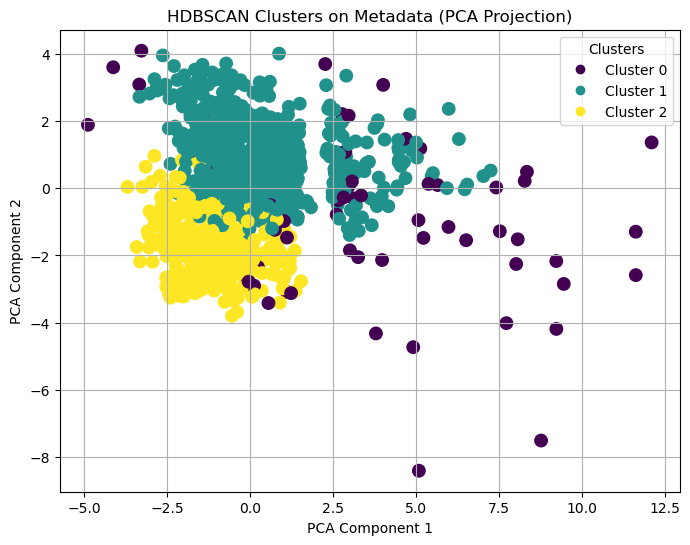

In [609]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 1],
    c=meta_df["cluster"],
    s=80
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("HDBSCAN Clusters on Metadata (PCA Projection)")
plt.grid(True)

handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in range(len(set(meta_df['cluster'])))],
           title="Clusters")

plt.show()


### KMeans

In [619]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(meta_df.drop(columns=["label" , "group"]))
kmeans = KMeans(n_clusters=3, random_state=42)
meta_df["cluster"] = kmeans.fit_predict(X_scaled)
meta_df

,num_rows,sales_mean,sales_std,sales_cv,sales_skew,sales_kurtosis,closed_fraction,weekend_ratio,customers_mean,customers_std,pca_var_first,pca_components_90,store_type,assortment,competition_mean,competition_std,label,cluster,group
0,743,4593.7140,2435.7651,0.530239,-0.506928,-0.041492,0.160162,0.829754,537.504711,265.109817,0.997754,1,0,0,540.0,0.0,store_44,0,easy
1,741,5661.2210,2928.6194,0.517312,-0.786354,0.092722,0.172740,0.939018,514.367072,258.919846,0.000000,18,0,2,8090.0,0.0,store_346,1,medium
2,754,5204.5977,2756.3560,0.529600,-0.568414,-0.033909,0.157825,0.800631,691.066313,344.848645,0.000000,18,0,2,670.0,0.0,store_331,1,easy
3,761,5704.5786,2961.0244,0.519061,-0.701369,0.099789,0.168200,1.059587,474.249671,231.376864,0.997550,1,3,2,9230.0,0.0,store_572,0,easy
4,760,10132.8430,6128.6270,0.604828,-0.221403,-0.675996,0.171053,0.553850,1120.869565,638.839728,0.996584,1,0,2,210.0,0.0,store_1014,2,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,5103.3135,2652.5212,0.519764,-0.792899,0.236228,0.170929,0.962292,546.318977,267.520106,0.996651,1,3,2,15720.0,0.0,store_588,0,easy
1111,739,3603.9182,2032.6263,0.564005,-0.292446,0.045020,0.162382,0.755790,437.604871,222.133675,0.000000,18,0,0,2320.0,0.0,store_486,1,easy
1112,770,5511.5947,3165.9922,0.574424,-0.402313,-0.381137,0.181818,0.772786,607.420779,327.400547,0.998231,1,0,0,7240.0,0.0,store_917,0,easy
1113,751,7614.8384,3988.4440,0.523773,-0.681120,-0.194850,0.162450,0.844251,733.103862,365.779886,0.997582,1,0,0,2850.0,0.0,store_683,0,medium


In [620]:
meta_df["cluster"].value_counts()

cluster
0    654
1    322
2    139
Name: count, dtype: int64

In [621]:
meta_df[meta_df["cluster"] == 2]["group"].value_counts()

group
hard      61
medium    61
easy      17
Name: count, dtype: int64

In [622]:
meta_df[meta_df["cluster"] == 1]["group"].value_counts()

group
easy      244
medium     66
hard       12
Name: count, dtype: int64

In [623]:
meta_df[meta_df["cluster"] == 0]["group"].value_counts()

group
easy      515
medium    108
hard       31
Name: count, dtype: int64

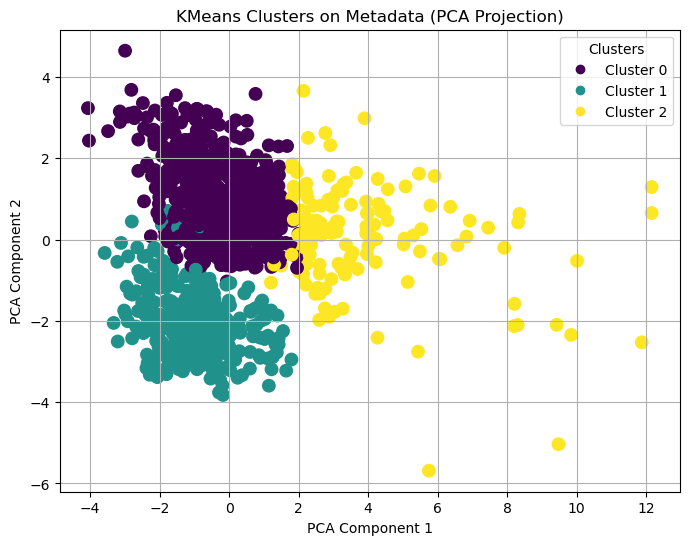

In [624]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 1],
    c=meta_df["cluster"],
    s=80
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clusters on Metadata (PCA Projection)")
plt.grid(True)

handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in range(len(set(meta_df['cluster'])))],
           title="Clusters")

plt.show()


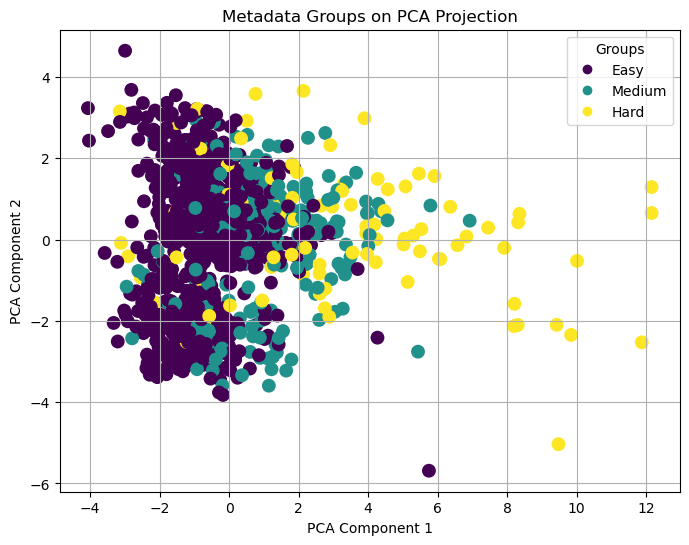

In [625]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming X_scaled contains your metadata features
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
# Use 'group' column for coloring
scatter = plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 1],
    c=meta_df["group"].map({"easy": 0, "medium": 1, "hard": 2}),  # convert to integers for colors
    s=80,
    cmap='viridis'
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Metadata Groups on PCA Projection")
plt.grid(True)

# Create legend manually
handles, labels = scatter.legend_elements()
plt.legend(handles, ["Easy", "Medium", "Hard"], title="Groups")

plt.show()


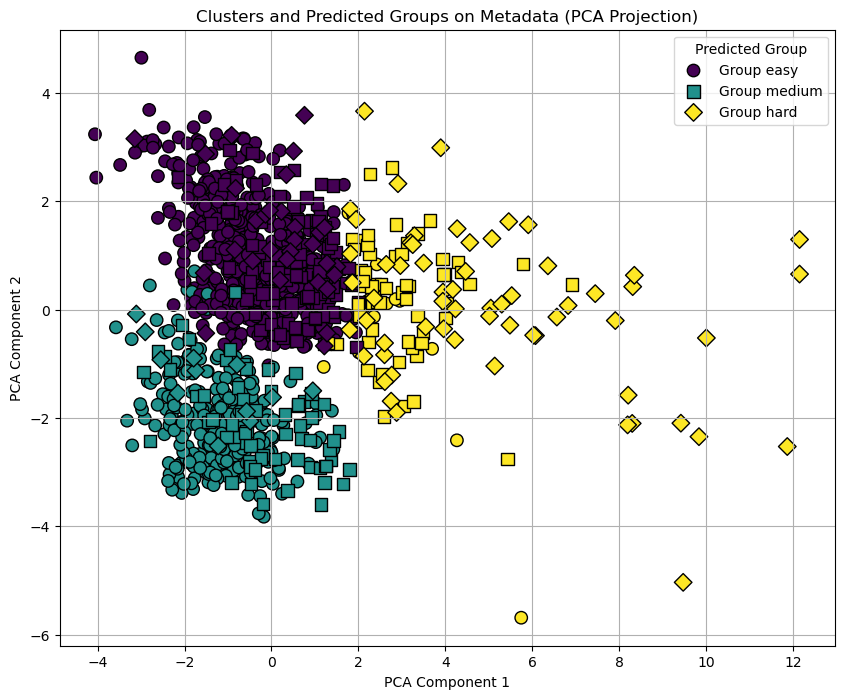

In [626]:
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle

# Fit PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

# Define unique groups for markers
groups = meta_df["group"].unique()
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # Add more if needed
group_marker_map = {g: markers[i % len(markers)] for i, g in enumerate(groups)}

plt.figure(figsize=(10, 8))

for group in groups:
    idx = meta_df["group"] == group
    plt.scatter(
        pca_coords[idx, 0],
        pca_coords[idx, 1],
        c=meta_df.loc[idx, "cluster"],  # color = cluster
        s=80,
        marker=group_marker_map[group],
        edgecolor='k',  # optional: black edge
        label=f"Group {group}"
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters and Predicted Groups on Metadata (PCA Projection)")
plt.grid(True)

# Legend for groups
plt.legend(title="Predicted Group")
plt.show()


In [627]:
meta_df

,num_rows,sales_mean,sales_std,sales_cv,sales_skew,sales_kurtosis,closed_fraction,weekend_ratio,customers_mean,customers_std,pca_var_first,pca_components_90,store_type,assortment,competition_mean,competition_std,label,cluster,group
0,743,4593.7140,2435.7651,0.530239,-0.506928,-0.041492,0.160162,0.829754,537.504711,265.109817,0.997754,1,0,0,540.0,0.0,store_44,0,easy
1,741,5661.2210,2928.6194,0.517312,-0.786354,0.092722,0.172740,0.939018,514.367072,258.919846,0.000000,18,0,2,8090.0,0.0,store_346,1,medium
2,754,5204.5977,2756.3560,0.529600,-0.568414,-0.033909,0.157825,0.800631,691.066313,344.848645,0.000000,18,0,2,670.0,0.0,store_331,1,easy
3,761,5704.5786,2961.0244,0.519061,-0.701369,0.099789,0.168200,1.059587,474.249671,231.376864,0.997550,1,3,2,9230.0,0.0,store_572,0,easy
4,760,10132.8430,6128.6270,0.604828,-0.221403,-0.675996,0.171053,0.553850,1120.869565,638.839728,0.996584,1,0,2,210.0,0.0,store_1014,2,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,5103.3135,2652.5212,0.519764,-0.792899,0.236228,0.170929,0.962292,546.318977,267.520106,0.996651,1,3,2,15720.0,0.0,store_588,0,easy
1111,739,3603.9182,2032.6263,0.564005,-0.292446,0.045020,0.162382,0.755790,437.604871,222.133675,0.000000,18,0,0,2320.0,0.0,store_486,1,easy
1112,770,5511.5947,3165.9922,0.574424,-0.402313,-0.381137,0.181818,0.772786,607.420779,327.400547,0.998231,1,0,0,7240.0,0.0,store_917,0,easy
1113,751,7614.8384,3988.4440,0.523773,-0.681120,-0.194850,0.162450,0.844251,733.103862,365.779886,0.997582,1,0,0,2850.0,0.0,store_683,0,medium


In [628]:
meta_df["cluster"].value_counts(())

cluster
0    654
1    322
2    139
Name: count, dtype: int64

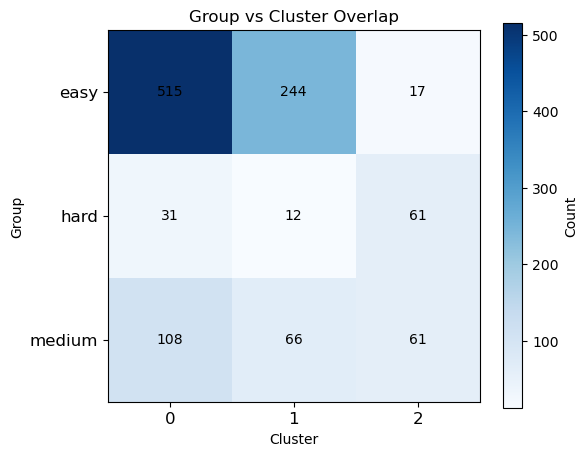

In [629]:
# compare cluster and group based on RMSE
ct = pd.crosstab(meta_df["group"], meta_df["cluster"])

plt.figure(figsize=(6,5))
plt.imshow(ct, cmap="Blues")

plt.colorbar(label="Count")

# Tick labels
plt.xticks(range(ct.shape[1]), ct.columns, fontsize=12)
plt.yticks(range(ct.shape[0]), ct.index, fontsize=12)

plt.xlabel("Cluster")
plt.ylabel("Group")
plt.title("Group vs Cluster Overlap")

# Annotate counts
for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        plt.text(j, i, ct.iloc[i, j], ha="center", va="center", color="black")

plt.show()


## 4. Train a decision tree to group datasets 

3 approaches:
1. Train a decision tree on all the meta data. More interpretable than random forest in general but because there are many features in the meta data, it is not easy to underestand the logic perfectly. Also the percision is around 82%.
2. Train a random forest on all the meta data. The percision is around 81 percent. However, it is difficult to interpret the logic behind random forest because there are many trees in it. 
3. Train a random forest to detect the most important and influencial features, then train the decision tree on those features only. This had the better percision of 82%. Also it is more interpretabel and we can actually expand the tree and see the logic behind it. 

In [16]:
# For the purpose of grouping (training the decision tree),  use the one giant model for all the stores and Compute per-store RMSE and group them. 
# Stores with bad RMSE → “hard” group
# Stores with average RMSE → “medium”
# Stores with good RMSE → “easy”

In [58]:
global_predictor = TabularPredictor.load("AutogluonModels_5min/")

In [128]:

store_rmses = {}

for name, df in stores.items():
    perf = global_predictor.evaluate(df)
    store_rmses[name] = abs(perf["root_mean_squared_error"])

with open("store_rmses.json", "w") as f:
    json.dump(store_rmses, f, indent=4)


KeyError: 'Sales'

In [510]:
with open("store_rmses.json", "r") as f:
    store_rmses = json.load(f)

store_rmses

{'store_44': 427.03360952640526,
 'store_346': 616.0141636042241,
 'store_331': 585.7557191763498,
 'store_572': 496.19500154528595,
 'store_1014': 1172.7844553164641,
 'store_630': 527.3283023811134,
 'store_545': 611.9078797703415,
 'store_201': 461.2834438514096,
 'store_1096': 435.2329064714001,
 'store_1111': 501.838246002304,
 'store_918': 421.03967884933223,
 'store_563': 491.76494007260885,
 'store_731': 584.2620050975702,
 'store_406': 479.52061758359474,
 'store_1040': 633.5579906504358,
 'store_232': 539.8962895168451,
 'store_134': 358.65287362622064,
 'store_155': 495.7663021096319,
 'store_221': 442.1392740704735,
 'store_250': 625.1845422574472,
 'store_94': 532.3873351593719,
 'store_653': 435.4116964003884,
 'store_578': 745.6263852670043,
 'store_65': 420.62767621076904,
 'store_872': 698.0791689271243,
 'store_1064': 584.5034327434446,
 'store_915': 520.6622854562602,
 'store_512': 549.3284800840382,
 'store_370': 530.0990407088868,
 'store_714': 430.48988606307967,


In [511]:
def assign_group_by_rmse(rmse):
    if rmse > 800:
        return "hard"
    elif rmse > 600:
        return "medium"
    else:
        return "easy"

meta_df["group"] = meta_df["label"].apply(lambda s: assign_group_by_rmse(store_rmses[s]))


In [512]:
meta_df["group"].value_counts()

group
easy      776
medium    235
hard      104
Name: count, dtype: int64

In [611]:
meta_df

,num_rows,sales_mean,sales_std,sales_cv,sales_skew,sales_kurtosis,closed_fraction,weekend_ratio,customers_mean,customers_std,pca_var_first,pca_components_90,store_type,assortment,competition_mean,competition_std,label,cluster,group
0,743,4593.7140,2435.7651,0.530239,-0.506928,-0.041492,0.160162,0.829754,537.504711,265.109817,0.997754,1,0,0,540.0,0.0,store_44,0,easy
1,741,5661.2210,2928.6194,0.517312,-0.786354,0.092722,0.172740,0.939018,514.367072,258.919846,0.000000,18,0,2,8090.0,0.0,store_346,1,medium
2,754,5204.5977,2756.3560,0.529600,-0.568414,-0.033909,0.157825,0.800631,691.066313,344.848645,0.000000,18,0,2,670.0,0.0,store_331,1,easy
3,761,5704.5786,2961.0244,0.519061,-0.701369,0.099789,0.168200,1.059587,474.249671,231.376864,0.997550,1,3,2,9230.0,0.0,store_572,0,easy
4,760,10132.8430,6128.6270,0.604828,-0.221403,-0.675996,0.171053,0.553850,1120.869565,638.839728,0.996584,1,0,2,210.0,0.0,store_1014,-1,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,743,5103.3135,2652.5212,0.519764,-0.792899,0.236228,0.170929,0.962292,546.318977,267.520106,0.996651,1,3,2,15720.0,0.0,store_588,0,easy
1111,739,3603.9182,2032.6263,0.564005,-0.292446,0.045020,0.162382,0.755790,437.604871,222.133675,0.000000,18,0,0,2320.0,0.0,store_486,1,easy
1112,770,5511.5947,3165.9922,0.574424,-0.402313,-0.381137,0.181818,0.772786,607.420779,327.400547,0.998231,1,0,0,7240.0,0.0,store_917,0,easy
1113,751,7614.8384,3988.4440,0.523773,-0.681120,-0.194850,0.162450,0.844251,733.103862,365.779886,0.997582,1,0,0,2850.0,0.0,store_683,0,medium


### 1. Tree

In [612]:
# tree
X = meta_df.drop(columns=["group" , "label" , "cluster" ])
y = meta_df["group"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [613]:
pred = tree_model.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

Accuracy: 0.7741935483870968


In [614]:
'''
# expand tree model

plt.figure(figsize=(200,100))
tree.plot_tree(
    tree_model,
    filled=True,
    feature_names=X_train.columns,
    class_names=[str(c) for c in tree_model.classes_]
)
plt.show()
'''

'\n# expand tree model\n\nplt.figure(figsize=(200,100))\ntree.plot_tree(\n    tree_model,\n    filled=True,\n    feature_names=X_train.columns,\n    class_names=[str(c) for c in tree_model.classes_]\n)\nplt.show()\n'

### 2. Random Forest

In [615]:
# random forest

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42
)

X = meta_df.drop(columns=["group" , "label" , "cluster"])
y = meta_df["group"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [616]:
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

Accuracy: 0.7992831541218638


### 3. Random Forest and then Decision Tree

In [ ]:
# Random Forest

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42
)

X = meta_df.drop(columns=["group" , "label" , "cluster" ])
y = meta_df["group"]

clf.fit(X, y)

importances =clf.feature_importances_
feature_names = X.columns

# Visualization
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp_df)

              feature  importance
1          sales_mean    0.188372
2           sales_std    0.166706
8      customers_mean    0.104655
9       customers_std    0.103063
6     closed_fraction    0.068442
10      pca_var_first    0.055805
3            sales_cv    0.050633
14   competition_mean    0.049651
7       weekend_ratio    0.047182
4          sales_skew    0.046599
0            num_rows    0.039997
5      sales_kurtosis    0.037466
16            cluster    0.018661
13         assortment    0.008730
12         store_type    0.007498
11  pca_components_90    0.006542
15    competition_std    0.000000


In [568]:
# Decision Tree
top_features = feat_imp_df["feature"].head(5).tolist()
X_top = meta_df[top_features]
y = meta_df["group"]
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.25, random_state=42, stratify=y
)

top_features_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
top_features_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [569]:
X_test = X_test[top_features]
pred = top_features_tree.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

Accuracy: 0.7741935483870968


In [570]:

plt.figure(figsize=(200,100))
tree.plot_tree(
    top_features_tree,
    filled=True,
    feature_names=X_train.columns,
    class_names=[str(c) for c in top_features_tree.classes_]
)
plt.show()


KeyboardInterrupt: 

## 5. Train an AutoGluon model for each group

In [ ]:

# Train a model for each group
group_models = {}

for group in meta_df["group"].unique():
    print("Training model for group:", group)
    
    # get store names in this group
    store_names = meta_df[meta_df["group"] == group]["label"].tolist()
    
    # merge datasets from all stores in this group
    group_df = pd.concat([stores[name] for name in store_names], ignore_index=True)
    
    # train model for this group
    predictor = TabularPredictor(
        label="Sales",
        path=f"Models_group/{group}/"
    ).fit(
        group_df,
        presets="best",
        time_limit=600,
        dynamic_stacking=False
    )

    group_models[group] = predictor
    

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       1.41 GB / 8.00 GB (17.6%)
Disk Space Avail:   53.99 GB / 228.27 GB (23.6%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1


Training model for group: easy


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Models_group/easy"
Train Data Rows:    565133
Train Data Columns: 19
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (22746, 0, 4993.23247, 3027.47469)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1587.05 MB
	Train Data (Original)  Memory Usage: 160.61 MB (10.1% of available memory)
	Inferring data type of each feature based on column values. Se

Training model for group: medium


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Models_group/medium"
Train Data Rows:    171702
Train Data Columns: 19
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (31311, 0, 6990.42456, 4101.84785)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1799.41 MB
	Train Data (Original)  Memory Usage: 48.80 MB (2.7% of available memory)
	Inferring data type of each feature based on column values. Se

Training model for group: hard


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Models_group/hard"
Train Data Rows:    76929
Train Data Columns: 19
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (41551, 0, 8796.03619, 5919.13579)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2522.74 MB
	Train Data (Original)  Memory Usage: 21.86 MB (0.9% of available memory)
	Inferring data type of each feature based on column values. Set f

In [ ]:
group_models

{'easy': <autogluon.tabular.predictor.predictor.TabularPredictor at 0x14ddb73d0>,
 'medium': <autogluon.tabular.predictor.predictor.TabularPredictor at 0x14dd58690>,
 'hard': <autogluon.tabular.predictor.predictor.TabularPredictor at 0x15035c090>}

## 6. Final Pipeline

In [429]:
def predict_for_dataset(df):
    
    # 1. Compute metadata
    new_df = df.copy()
    new_df["PredictedSales"] = global_predictor.predict(new_df)
    metadata = compute_metadata(new_df)
    meta_vec = pd.DataFrame([metadata])

    
    # 2. Predict group with probabilities*
    probs = clf.predict_proba(meta_vec)[0]
    confidence = max(probs)
    pred_group = clf.classes_[np.argmax(probs)]
    
    print("Predicted group:", pred_group)
    print("Prediction confidence:", confidence)
    
    # 3. Fallback: if confidence is too low → use global model instead
    if confidence < 0.5:
        print("Low confidence — using global model instead.")
        return global_predictor.predict(new_df), global_predictor.evaluate(new_df)
    
    # 4. Load the correct group model
    predictor = TabularPredictor.load(f"Models_group/{pred_group}/")
    
    # 5. Predict using selected group model
    preds = predictor.predict(new_df)
    evals = predictor.evaluate(new_df)
    
    return preds , evals


## 7. Usage

In [571]:
meta_df[meta_df["group"] == "hard"]

,num_rows,sales_mean,sales_std,sales_cv,sales_skew,sales_kurtosis,closed_fraction,weekend_ratio,customers_mean,customers_std,pca_var_first,pca_components_90,store_type,assortment,competition_mean,competition_std,label,cluster,group
4,760,10132.8430,6128.6270,0.604828,-0.221403,-0.675996,0.171053,0.553850,1120.869565,638.839728,0.996584,1,0,2,210.0,0.0,store_1014,1,hard
51,740,5878.4424,3370.5603,0.573376,-0.389477,-0.176776,0.185135,1.034885,776.105405,407.864152,0.986817,1,0,0,180.0,0.0,store_264,3,hard
62,610,9577.4880,4858.6636,0.507300,-1.076623,0.109799,0.178689,1.267685,674.396721,336.303771,0.997926,1,3,2,7290.0,0.0,store_903,2,hard
64,731,8958.3050,4665.8486,0.520841,-0.849287,-0.096067,0.176471,1.019137,1044.448700,517.489568,0.990401,1,0,0,90.0,0.0,store_906,1,hard
68,773,11131.5090,5671.1610,0.509469,-0.922464,0.143039,0.170763,1.194500,1332.499353,650.175689,0.998222,1,0,2,20390.0,0.0,store_467,1,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,609,14872.0100,8026.9585,0.539736,-0.924103,-0.257072,0.195402,1.316572,919.995074,481.910471,0.998050,1,3,2,1200.0,0.0,store_842,1,hard
1063,729,8030.7010,4399.7210,0.547863,-0.383932,0.010469,0.163237,1.548979,847.519890,436.556490,0.996930,1,2,2,3530.0,0.0,store_421,1,hard
1074,770,7631.9116,4373.8670,0.573102,-0.407615,-0.292969,0.181818,0.986672,977.003896,507.089283,0.000000,18,2,0,210.0,0.0,store_387,0,hard
1095,750,11445.5030,5384.0460,0.470407,-1.282873,0.587389,0.160000,1.060657,1357.245333,624.483153,0.997664,1,0,0,580.0,0.0,store_546,1,hard


In [572]:
incoming_df = stores["store_903"]

In [573]:
preds = predict_for_dataset(incoming_df)
preds

Predicted group: medium
Prediction confidence: 0.518638888888889


(65           -1.639831
 776          49.279755
 798       12872.029297
 5808      11809.750977
 7273      11885.339844
               ...     
 809038    14596.875000
 810053    11966.483398
 810368    12175.750000
 811167    11888.096680
 812046    10125.597656
 Name: Sales, Length: 610, dtype: float32,
 {'root_mean_squared_error': np.float64(-947.6798081907504),
  'mean_squared_error': -898097.125,
  'mean_absolute_error': -716.145263671875,
  'r2': 0.9634023904800415,
  'pearsonr': 0.9922673103343023,
  'median_absolute_error': -640.95166015625})

In [574]:
global_predictor.evaluate(incoming_df)


{'root_mean_squared_error': np.float64(-448.62161078856207),
 'mean_squared_error': -201261.34375,
 'mean_absolute_error': -325.2724914550781,
 'r2': 0.9917985796928406,
 'pearsonr': 0.9959636332625522,
 'median_absolute_error': -250.11376953125}

In [277]:
# seems like the small models work better on the hard datasets but worse on the easy datasets?! And for medium is almost the same.

In [278]:
# The provlem is when the decison tree predicts incorrectly and use the wrong model for it. We need to make sure that this does not happen.
# store 264 was a good example of that. With using the simple meta data and decision tree, it was predicted an easy dataset however it was a hard one, therefore it used the easy model on it which worked awfully. (RMSE=2590)
# But with the use of random forest and the new metadata calculation it was predicted as a hard dataset and by using the hard model the evaluation results were also much better than the global model.
# That is why we use a threshod for the prediction score now. 

In [ ]:
# Right now it seems like clustering the datasets does not help at all because it is not in the most important features for the random forest to learn from. 
# 3 ideas with clustering:
# 1. Use clustering labels instead of RMSE hard, medium, easy. Use these clusters as the labels and compare it with the previous approach. -> tried it and it does not work. There is no guarantee that the datasets that are in the same cluster have the same RMSE therefore there are clusters which hard and easy ones at the same time. 
# 2. Use clustering as a meta data feaure and train the decision tree on all the meta data. -> it is not really useful because the RMSE groups are independent of clusters.
# 3. USe clustering after the decision tree, but this also does not help if the decision tree is predicting wrongly in the fisrt place.


In [ ]:
# Do we even have enough datasets in GlobalFoundries to train on metadata of the datasets?
# is it possible that the data in Globalfoundries is more complex and has more features therefore iw would get a better performance for decision tree?

The problem is the decision tree performance is not really good (77%). could it be better on the real data?


I think the problem is the meta data for different datasets are really similar. The random forest feature importance shows us that the model is not really learning anythin meaningful from the metdata. 


                      feature  importance
7               open_fraction    0.108921
14              pca_var_first    0.107284
8   competition_distance_mean    0.097528
10               avg_skewness    0.093676
11               avg_kurtosis    0.092725
12         avg_coef_variation    0.070244
1           dayofweek_entropy    0.066819
6      schoolholiday_fraction    0.060746
3          weekofyear_entropy    0.059358
4              promo_fraction    0.057316
13         std_coef_variation    0.056905
2               month_entropy    0.056857
0                    num_rows    0.051832
5             promo2_fraction    0.008034
15          pca_components_90    0.006318
16                    cluster    0.005436
9    competition_distance_std    0.000000



So the metadata alone is not really helping. The question is first, are there enough datasets for meta training at the company? 2. Are they different enough so that the decision tree can actually learn someting useful?